In the previous lesson, we looked at some examples of the movie embeddings we learned, measured the distances between pairs of movies, looked up movies most similar to certain movies, and had some fun composing the semantics of movies with vector math. These are great ways to debug an embedding model, or understand how it works. But it's also pretty time-consuming.

In this lesson you'll learn how to use the t-SNE algorithm to visualize embeddings. This is a nice cheap technique for understanding the nature of your embeddings.

# t-SNE?

Visualizing data in 1 or 2 dimensions is easy - but it's not clear how to visualize embeddings which are 8-dimensional or 32-dimensional. t-SNE is a **dimensionality reduction** algorithm which is often used for visualization. It learns a mapping from a set of high-dimensional vectors, to a space with a smaller number of dimensions (usually 2), which is hopefully a good representation of the high-dimensional space.

What makes a mapping a "good representation"? Put simply, t-SNE tries to make sure that if high-dimensional vectors $\mathbf{u}$ and $\mathbf{v}$ are close together, then $map(\mathbf{u})$ and $map(\mathbf{v})$ are close together in the 2-d mapping space.

# The code

To start, we'll load our pretrained embeddings, like before.

In [ ]:
#$HIDE$
%matplotlib inline
import random
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

RUNNING_ON_KERNELS = 'KAGGLE_WORKING_DIR' in os.environ
input_dir = '../input/0-movielens-preprocessing' if RUNNING_ON_KERNELS else '../input/movielens_preprocessed'
model_dir = '../input/x3-movielens-spiffy-model' if RUNNING_ON_KERNELS else '.'
model_path = os.path.join(model_dir, 'movie_svd_model_32.h5')

model = keras.models.load_model(model_path)
emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()

movies_path = os.path.join(input_dir, 'movie.csv')
movies_df = pd.read_csv(movies_path, index_col=0)

As we saw in our earlier lesson, our dataset has lots of obscure movies with few ratings (sometimes as few as one). We know so little about these movies that their embeddings are as good as random. We can clarify our visualization by selecting only movies that meet some popularity threshold.

In [ ]:
threshold = 100
mainstream_movies = movies_df[movies_df.n_ratings >= threshold].reset_index(drop=True)
print("Went from {} to {} movies after applying threshold".format(
    len(movies_df), len(mainstream_movies),
))
w_full = w
w = w[mainstream_movies.movieId]
df = mainstream_movies

Went from 26744 to 8546 movies after applying threshold


We'll be using [scikit-learn's t-SNE implementation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

I mentioned that t-SNE tries to preserve "closeness" between entities in the feature space. As we saw in the previous lessons, there are a lot of competing notions of distance. By default, t-SNE uses euclidean distance. But because cosine distance is known to work well on embeddings, we'll pass in `metric="cosine"` when creating the model.

In [ ]:
from sklearn.manifold import TSNE

if RUNNING_ON_KERNELS:
    # The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
    # out some marginal improvements. NB: This takes almost an hour!
    tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

    embs = tsne.fit_transform(w)
    # Add to dataframe for convenience
    df['x'] = embs[:, 0]
    df['y'] = embs[:, 1]
else:
    df = pd.read_csv('movies_tsne.csv', index_col=0)
    embs = df[ ['x', 'y'] ].values

In [ ]:
#$HIDE_INPUT$
# Save a copy of our t-SNE mapping data for later use (we'll be loading this file in the exercise)
if RUNNING_ON_KERNELS:
    df.to_csv('movies_tsne.csv')

Here's a sample of the 2-d vectors we've mapped our movies to:

In [ ]:
embs[:5]

array([[  49.067574,  -72.78283 ],
       [-137.91568 ,  -64.97175 ],
       [-140.84956 ,  -59.876312],
       [-121.19009 ,  -63.6731  ],
       [-140.11511 ,  -60.27765 ]])

The whole point of doing this dimensionality reduction was visualization, so let's use matplotlib to draw a scatter plot of our movies, using our new 2-d mapping.

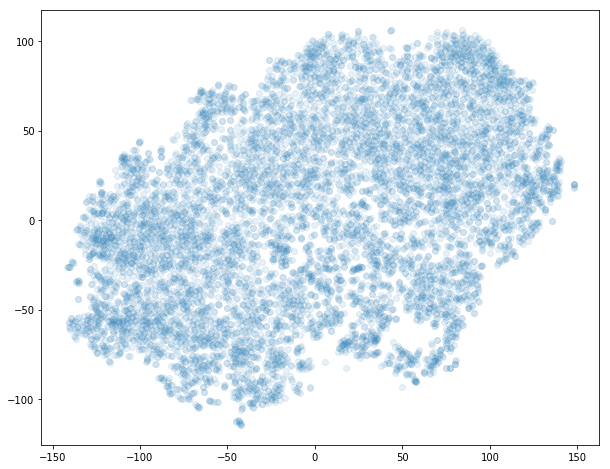

In [ ]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

# Did it work? 

It's hard to judge by the shape alone. A good sanity check is to identify some groups of movies that we strongly believe *should* be close together, and see whether they're close in the 2-d space.

For example, all the Harry Potter movies should be close together, right?

In [ ]:
#$HIDE_INPUT$
# Some helper functions for plotting annotated t-SNE visualizations

# TODO: adjust_text not available in kernels
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

# Actually let's just nuke this for now so we can see locally what plots will look like
# on kernels (assuming we can't get aT in the docker img in time)
def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def plot_groups(index_groups, labels, text=False, marker='o', alpha=1, s=None, **kwargs):
    assert not text
    ax = plot_bg(**kwargs)
    for indices, label in zip(index_groups, labels):
        x = embs[indices, 0]
        y = embs[indices, 1]
        ax.scatter(x, y, label=label, alpha=alpha, marker=marker, s=s)
    plt.legend()


    
def plot_title_patterns(patterns, **kwargs):
    index_groups = [
        df[df.title.str.contains(patt)].index
        for patt in patterns
    ]
    plot_groups(index_groups, patterns, **kwargs)

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

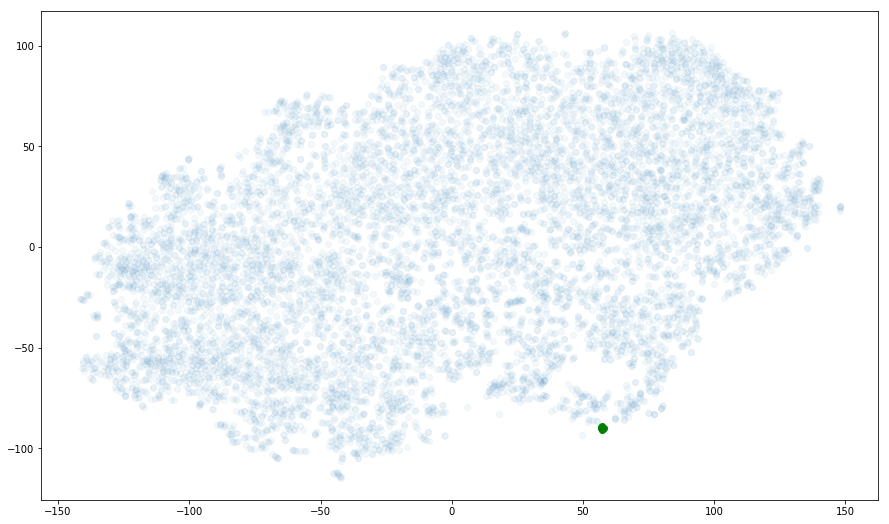

In [ ]:
# This and several other helper functions are defined in a code cell above. Hit the "code"
# button above if you're curious about how they're implemented.
plot_by_title_pattern('Harry Potter', figsize=(15, 9), bg_alpha=.05, text=False);

The plot above has a green dot for each of the 8 Harry Potter movies - but they're so close together, they're impossible to distinguish at this scale. That's a good sign!

Let's zoom in to get a closer look.

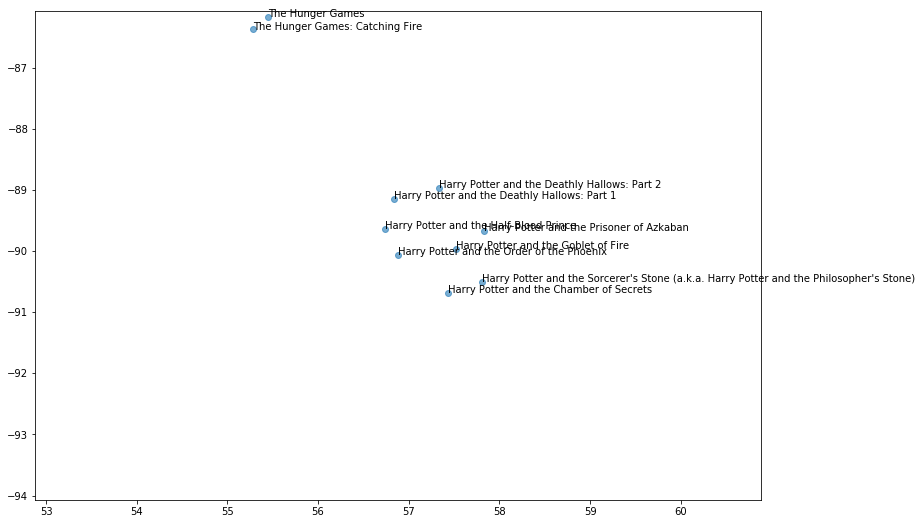

In [ ]:
plot_region_around('Harry Potter and the Order of the Phoenix', 4);

Not only are the Harry Potter movies tightly clustered, they're arranged roughly in order of release!

<!-- TODO. Lest you think we just got lucky this time, feel free to click the "output" button on any of the below cells to see some more examples of how our mapping places movies from other franchises. -->

## Local vs. Global structure

One of the key features of t-SNE which makes it so good for visualization is that it's good at capturing clusters *at multiple scales*. We've seen that our mapping is successfully capturing small, tight, local structures. What about bigger structures encompassing more loosely related movies?

We've already seen a small example of this above: the closest neighbours to the Harry Potter movies are movies from the *Hunger Games* series - another set of movies based on a series of young adult fantasy books. Makes sense!

What about less niche genres? Where do documentaries fall?

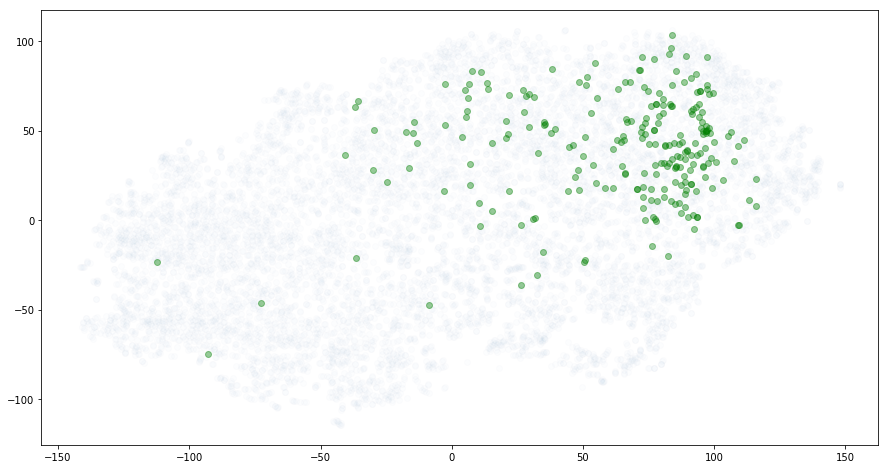

In [ ]:
docs = df[ (df.genres == 'Documentary') ]
plot_with_annotations(docs.index, text=False, alpha=.4, figsize=(15, 8));

Nice! It's not a tight cluster, but there's definitely a strong pattern here.

And just to reiterate: we never actually showed the model genre as a feature. It can't read the titles to see that *Harry Potter and the Philosopher's Stone* and *Harry Potter and the Chamber of Secrets* belong to the same series. It managed to pick up these latent patterns and incorporate them into the embedding space just by seeing data points like "user 5299 gave movie 806 a rating of 4.5". Pretty impressive!

Here's another, slightly more complicated genre experiment: visualizing all movies whose genres are a subset of `{Comedy, Drama, Romance}` (i.e. comedies, dramas, romances, dramedies, romantic dramas, romcoms, and... "dromcoms" I guess?)

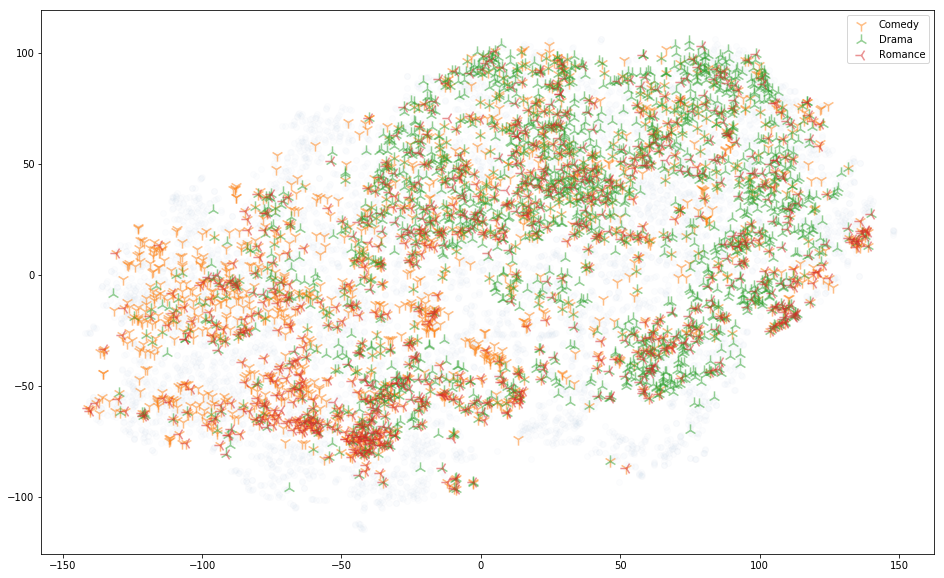

In [ ]:
#$HIDE_INPUT$
import itertools
sample_rate = 1
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 10))
dromcoms = df[df.genres.isin(genre_combos)]
if sample_rate != 1:
    dromcoms = dromcoms.sample(frac=sample_rate, random_state=1)
for i, genre in enumerate(genre_components):
    m = dromcoms[dromcoms.genres.str.contains(genre)]
    marker = str(i+1)
    add_annotations(ax, m.index, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
plt.legend();

This is an awesome example of structure at the largest scale. Dramas are mostly in the upper-right half, and comedies are mostly in the other half (with romances having a more spread-out, bursty distribution).

# Tuning t-SNE

We achieved good results using the default out-of-the box parameters for our t-SNE model, but depending on the characteristics of your data, you may not be so lucky.

t-SNE isn't a simple closed-form mathematical operation. You're training a model to minimize some non-convex loss function using stochastic gradient descent. It may take a while, and require a bit of fiddling. You may even see very different results between two t-SNE models trained with the same parameters (set a fixed `random_state` if you want reproducibility).

When tuning, I highly recommend creating your model with `verbose = True` to see what's happening during fitting. Among other things, it will report the error and the the gradient size every 50 iterations, which can help guide experimentation. For example, if the error rate is still decreasing after 1000 iterations (the default value of `n_iter`), you may want to try running it for more iterations next time. (I trained the t-SNE model above with more iterations for this reason).

An important parameter which is unique to t-SNE is **perplexity**. Roughly speaking, lowering perplexity places more importance on *local structure*, and increasing it emphasizes large-scale, *global structure*.

`TODO: I think this is useful information, but I don't like that the presentation violates the "show, don't tell" principle - and I think readers are less likely to absorb/remember it for that reason. Consider cutting? Or move to extra 'appendix' kernel along with canned perplexity stuff.`

# Your Turn



**TODO: exercise link**

# Further Reading

- If you're interested in more in-depth, mathematical detail on t-SNE, I highly recommend checking out [the original paper by Laurens van der Maaten and Geoff Hinton that introduced t-SNE to the world](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).
- [How to Use t-SNE effectively](https://distill.pub/2016/misread-tsne/) features some incredible live, interactive examples, allowing you to apply t-SNE to various synthetic datasets and watch the training happen in real-time, and see the effect of changing parameters like the perplexity.
- The [sklearn TSNE docs](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) have good information on the meaning of each parameter, and some tips for setting them.
    - See also: [scikit-learn's t-SNE user guide](http://scikit-learn.org/stable/modules/manifold.html#t-sne)
- [t-SNE FAQ](https://lvdmaaten.github.io/tsne/#faq) written by Laurens van der Maaten

`</tutorial>`

# Scratch space below - please ignore

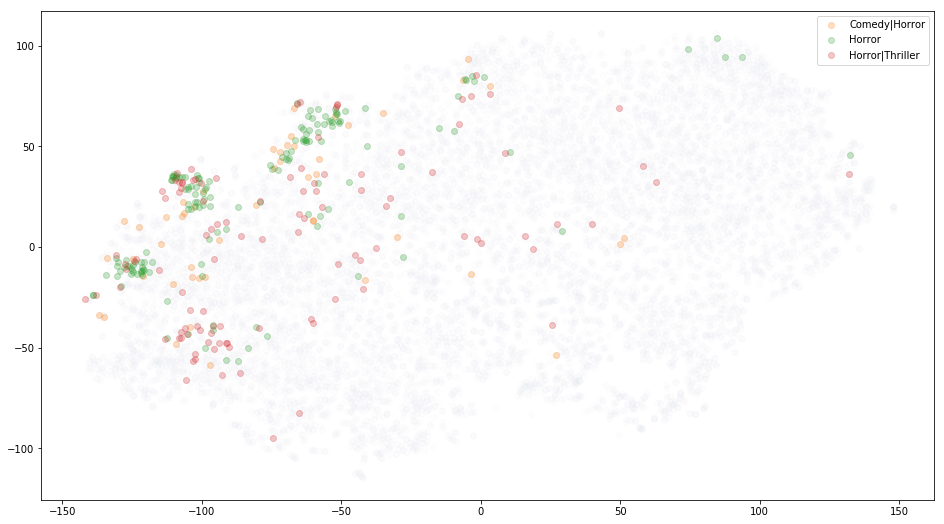

In [ ]:
genre_counts = df.groupby('genres').size()
horror_genres = genre_counts[
    (genre_counts >= 45) & (genre_counts.index.str.contains('Horror'))
].index
sub = df[df.genres.isin(horror_genres)]
g = sub.groupby('genres')

ax = plot_bg(figsize=(16, 9), bg_alpha=.006)

for genre, group in g:
    add_annotations(ax, group.index, label=genre, alpha=.25)
plt.legend();

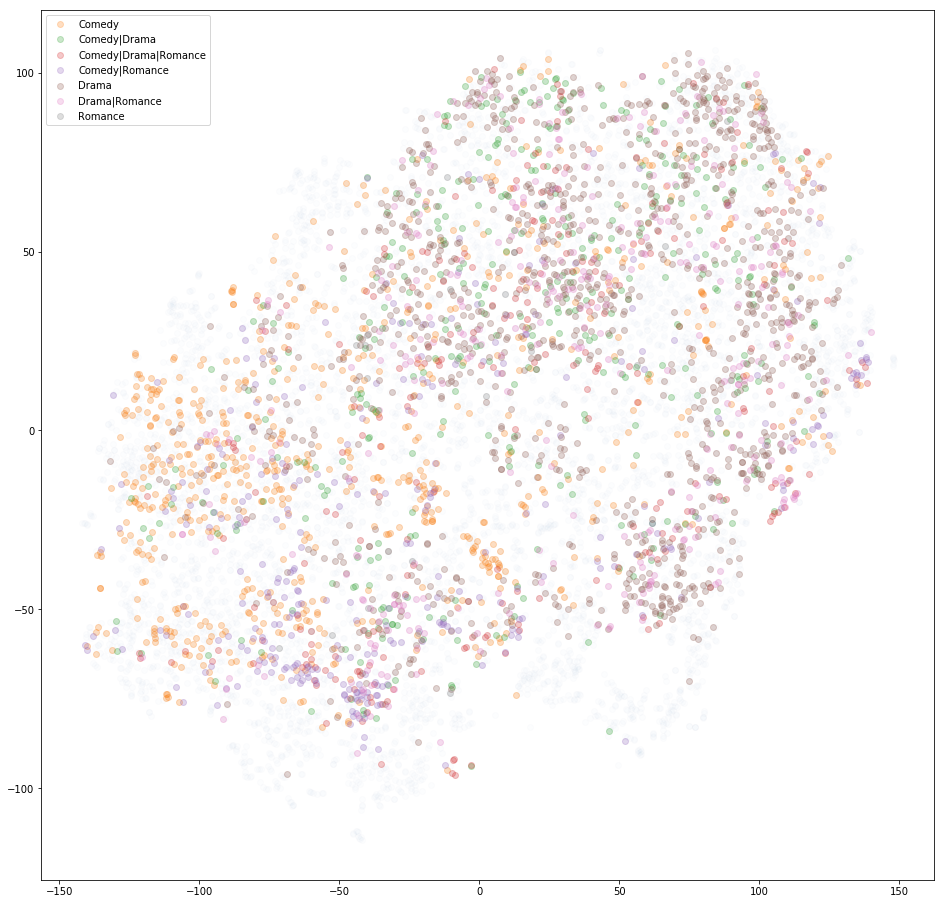

In [ ]:
# dromcoms 2
import itertools
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 16))
dromcoms = df[df.genres.isin(genre_combos)]
g = dromcoms.groupby('genres')
for genre, group in g:
    add_annotations(ax, group.index, label=genre, alpha=.25)
plt.legend();

## Notes/scratch

tips:
- monitor training by setting verbose=1
- experiment with params. 
- train on all data
- distance metric?

- TODO: maybe try running on another dataset as well? Wouldn't be so hard. Probably.

- would be cool to color by genre, or by...
    - avg. rating
    - MPAA rating
    - year
- plot many/all points, and add labels for just a certain subset at a time. e.g. Adam Sandler movies. Best Picture winners. etc.
- try generating a few maps with the same params (but no fixed seed). See how much variation exists between them.

question: train on all datapoints, then sample the ones to visualize? Or only train on the subset you're planning on visualizing?

Relevant quote:

> Obviously, it is possible to
pick a random subset of the datapoints and display them using t-SNE, but such an approach fails to 
make use of the information that the undisplayed datapoints provide about the underlying manifolds.
Suppose, for example, that A, B, and C are all equidistant in the high-dimensional space. If there
are many undisplayed datapoints between A and B and none between A and C, it is much more
likely that A and B are part of the same cluster than A and C. 

further reading: http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf (how it works, why it's useful specifically for viz, how it's different from stuff like PCA)

sklearn t-sne user guide looks like a good resource: http://scikit-learn.org/stable/modules/manifold.html#t-sne

goals: https://distill.pub/2016/misread-tsne/